# Solving Nurikabe using Genetic Algorithms

## The rules of the game

Each puzzle consists of a grid containing clues in various places. The object is to create islands by partitioning between clues with lakes so:

1) The number of squares in each `island` equals the value of the clue.
2) All `lakes` form a continuous path.
3) Each island contains a clue.
4) There are no `lakes` of 2x2 or larger.
5) All `islands` are isolated from each other horizontally and vertically.

In [1]:
# Import modules
import pygad
import time
import random
import statistics 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def solve_ga(nurikabe, difficulty):
        """
        Performs the genetic algorithm in order to get the solution for the nurikabe puzzle.

        Parameters
        ----------
        nurikabe :  ndarray
            puzzle which will be solved
        difficulty : int
            difficulty of the puzzle which will help to define:
                - number of solutions within the population
                - number of generations
                - percentage of genes to mutate

        Returns
        -------
        tuple
            solution to the given nurikabe puzzle and result of the fitness function
        """
    # Defining global variables which will be needed in order to calculate the effectivnes of the algorithm
    global solution, n_rows, n_cols
    
    # Will be used to convert the puzzle to a ndarray
    n_rows, n_cols = nurikabe.shape
    
    def get_island_size(grid, row, col):
        """
        Finds the size of the `island` [rule 1]
        
        Parameters
        ----------
        grid : ndarray
            nurikabe solution returned from GA
        row : int
            row of the solution 
        col : int
            column of the solution 
        
        Returns
        -------
        int
            size of the `island` for the given row and column in the solution 
        """
    
        # Create a copy of the solution matrix
        grid_island = grid.copy()
        
        # Check if the given coordinates correspond to an `island`
        if grid_island[row, col] == 0:
            return 0

        # Use flood fill algorithm to find the size of the `island`
        size = 0
        queue = [(row, col)]
        while len(queue) > 0:
            r, c = queue.pop(0)
            if grid_island[r, c] == 1:
                size += 1
                grid_island[r, c] = -1
                if r > 0:
                    queue.append((r-1, c))
                if r < grid_island.shape[0]-1:
                    queue.append((r+1, c))
                if c > 0:
                    queue.append((r, c-1))
                if c < grid_island.shape[1]-1:
                    queue.append((r, c+1))

        return size
    
    
    def lake_is_connected(grid):
        """
        Checks if all `lakes` are connected [rule 2]
        
        Parameters
        ----------
        grid : ndarray
            nurikabe solution returned from GA
        
        Returns
        -------
        bool
            True - all `lakes` form a continuous path
            False - otherwise
        """
        
        # Create a copy of the solution matrix
        grid_lake = grid.copy()
        
        # Replace all `island` cells with -1
        grid_lake[grid_lake == 1] = -1

        # Use flood fill algorithm to find all `lakes` in the solution
        lakes = []
        for row in range(grid_lake.shape[0]):
            for col in range(grid_lake.shape[1]):
                if grid_lake[row, col] == 0:
                    lake = []
                    queue = [(row, col)]
                    while len(queue) > 0:
                        r, c = queue.pop(0)
                        if grid_lake[r, c] == 0:
                            lake.append((r, c))
                            grid_lake[r, c] = -1
                            if r > 0:
                                queue.append((r-1, c))
                            if r < grid_lake.shape[0]-1:
                                queue.append((r+1, c))
                            if c > 0:
                                queue.append((r, c-1))
                            if c < grid_lake.shape[1]-1:
                                queue.append((r, c+1))
                    lakes.append(lake)

        # Check if all `lakes` are connected to each other
        for i in range(len(lakes)):
            for j in range(i+1, len(lakes)):
                if not any(cell in lakes[j] for cell in lakes[i]):
                    return False

        return True
    
    def lakes_have_numbers(grid):
        """
        Checks if all clues are `islands` [rule 3]
        
        Parameters
        ----------
        grid : ndarray
            nurikabe solution returned from GA
        
        Returns
        -------
        bool
            True - clue is a `lake` 
            False - otherwise
        """
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                if grid[i][j] == 0 and nurikabe[i][j] != 0:
                    return True
        return False
    
    def lake_2x2(grid):
        """
        Checks if there is a `lake` with a 2x2 cube [rule 4]
        
        Parameters
        ----------
        grid : ndarray
            nurikabe solution returned from GA
        
        Returns
        -------
        bool
            True - clue is a `lake` 
            False - otherwise
        """
        
        for i in range(grid.shape[0]-1):
            for j in range(grid.shape[1]-1):
                if grid[i][j] == 0 and grid[i+1][j] == 0 and grid[i][j+1] == 0 and grid[i+1][j+1] == 0:
                    return True
        return False
    
    
    def islands_connected(grid):
        """
        Checks if there are two connected `islands` [rule 5]
        
            In order to determine that the code will perform 3 steps:
                1) Group each `island` by the coordinates.
                2) Assign to each clue coordinates of the `island`.
                3) Check whether in any of the clues the coordinates are repeated.
            If the coordinates are repeated in any of the clues, then some of the islands must be connected.
            
        Parameters
        ----------
        grid : ndarray
            nurikabe solution returned from GA
        
        Returns
        -------
        bool
            True - any of the `islands` are connected 
            False - otherwise
        """
        
        
        # find the indices of all 1s in the array
        indices = np.argwhere(grid == 1)
        # create a dictionary to store the adjacent 1s
        adj_dict = {}
        for index in indices:
            # check if the index is adjacent to any previously found 1s
            adjacent = []
            if tuple(index - np.array([1, 0])) in adj_dict:
                adjacent.append(tuple(index - np.array([1, 0])))
            if tuple(index + np.array([1, 0])) in adj_dict:
                adjacent.append(tuple(index + np.array([1, 0])))
            if tuple(index - np.array([0, 1])) in adj_dict:
                adjacent.append(tuple(index - np.array([0, 1])))
            if tuple(index + np.array([0, 1])) in adj_dict:
                adjacent.append(tuple(index + np.array([0, 1])))
            # add the current index to the dictionary
            adj_dict[tuple(index)] = adjacent
            # update the adjacent 1s for all previously found 1s
            for adj_index in adjacent:
                adj_dict[adj_index].append(tuple(index))
                
        # group the adjacent 1s into separate lists
        groups = []
        while adj_dict:
            # create a new group and add the first index in the dictionary to it
            group = [list(adj_dict.keys())[0]]
            # loop through the group and add all adjacent indices to it
            for index in group:
                for adj_index in adj_dict[index]:
                    if adj_index not in group:
                        group.append(adj_index)
            # remove all indices in the group from the dictionary
            for index in group:
                del adj_dict[index]
            # add the group to the list of groups
            groups.append(group)
        # convert the list of groups to a list of lists of coordinates
        coords_list = []
        for group in groups:
            coords = [tuple(index) for index in group]
            coords_list.append(coords)

        neighbors = coords_list

        # create a dictionary to store clues and `islands` 
        islands = {}
        # get coordinates of the clues
        coords = np.argwhere(nurikabe != 0)
        # loop through the clues and add all coordinates of `islands` to it
        for coord in coords:
            for neighbor in neighbors:
                for n in neighbor:
                    if (coord == n).all():
                        islands[tuple(coord)] = neighbor
                        break

                        
        seen = set()
        duplicates = []
        
        # loop through the `island` coordinates assigned to clues and store duplicates 
        for key, value in islands.items():
            for element in value:
                if element in seen:
                    duplicates.append((key, element))
                else:
                    seen.add(element)

        if duplicates:
            return True
        else:
            return False
        
    # Define the fitness function
    def fitness_func(solution, solution_idx):
        """
        defines the fitness function for GA
            
            Fitness function defined as follows:
            1) Checks if sizes of an island in the solution matches the actual size. If so, add 1 to the fitness.
               This approach ensures that the big `islands` do not dominate the small ones.
            2) Checks if rules 2-5 of the game are met. If not, subtracts 100.
            
            Range of this function will be [-400, n] where n - number of clues. 
            
        
        Parameters
        ----------
        solution :
            single solution
        
        solution_idx : 
            its index in the population
            
        Returns
        -------
        int
            fitness value of the solution
        """
        
        # Convert the solution to a 2D grid
        grid = solution.reshape((n_rows, n_cols))
        grid = grid.astype(int)
        
        fitness = 0

        x = np.where(nurikabe != 0)[0]
        y = np.where(nurikabe != 0)[1]
        
        for i in range(len(x)):
            if nurikabe[x[i]][y[i]] == get_island_size(grid, x[i], y[i]):
                fitness += 1

        # Rule 2
        if lake_is_connected(grid) == False:
            fitness -= 100

        # Rule 3
        if lakes_have_numbers(grid) == True:
            fitness -= 100

        # Rule 4
        if lake_2x2(grid) == True:
            fitness -= 100
        
        # Rule 5
        if islands_connected(grid) == True:
            fitness -= 100
            
        return fitness



    fitness_function = fitness_func
    
    """
    Genes in our solution will be:
    0 - `lake`
    1 - `island`
    """
    gene_space = [0, 1]

    sol_per_pop = 100 * difficulty

    num_genes = len(nurikabe.ravel())

    num_parents_mating = 4
    num_generations = 20 * difficulty
    keep_parents = 2

    parent_selection_type = "sss"

    crossover_type = "single_point"

    mutation_type = "random"
    mutation_percent_genes = (2 / num_genes) * 100

    ga_instance = pygad.GA(gene_space = gene_space,
                           num_generations = num_generations,
                           num_parents_mating = num_parents_mating,
                           fitness_func = fitness_function,
                           sol_per_pop = sol_per_pop,
                           num_genes = num_genes,
                           parent_selection_type = parent_selection_type,
                           keep_parents = keep_parents,
                           crossover_type = crossover_type,
                           mutation_type = mutation_type,
                           mutation_percent_genes = mutation_percent_genes)

    ga_instance.run()


    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    return solution.reshape((n_rows, n_cols)), solution_fitness

Sources for puzzles and answers:
- https://pl.puzzle-nurikabe.com/

In [3]:
# first 5x5
nurikabe1 = np.array([
    [2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 4, 0, 0]
])

In [4]:
solve_ga(nurikabe1, 3)

(array([[1., 1., 0., 1., 1.],
        [0., 0., 1., 0., 0.],
        [1., 0., 1., 1., 0.],
        [0., 1., 0., 0., 1.],
        [1., 0., 1., 1., 1.]]),
 -96)

In [5]:
nurikabe1_ans = np.array([
    [1, 0, 0, 0, 0],
    [1, 0, 1, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 1],
    [0, 0, 1, 1, 1]
])

In [6]:
# second 5x5
nurikabe2 = np.array([
    [0, 0, 0, 2, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0],
    [0, 3, 0, 0, 0],
    [0, 0, 3, 0, 0]
])

In [7]:
solve_ga(nurikabe2, 3)

(array([[0., 0., 0., 1., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1.]]),
 4)

In [8]:
nurikabe2_ans = np.array([
    [0, 0, 0, 1, 1],
    [0, 1, 0, 0, 0],
    [0, 1, 0, 1, 1],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 1, 1]
])

In [9]:
# third 5x5
nurikabe3 = np.array([
    [0, 0, 0, 0, 2],
    [0, 0, 3, 0, 0],
    [3, 0, 0, 0, 0],
    [0, 0, 0, 0, 2],
    [0, 3, 0, 0, 0]
])

In [10]:
solve_ga(nurikabe3, 3)

(array([[1., 0., 1., 0., 1.],
        [1., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 1., 1., 0., 1.]]),
 5)

In [11]:
nurikabe3_ans = np.array([
    [1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1],
    [1, 0, 1, 0, 0],
    [0, 0, 0, 0, 1],
    [1, 1, 1, 0, 1]
])

In [12]:
# first 6x6
nurikabe4 = np.array([
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [3, 0, 0, 0, 0, 3],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 4, 0, 0, 0],
    [1, 0, 0, 0, 1, 0]
])

In [13]:
solve_ga(nurikabe4, 4)

(array([[0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 1.],
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0.]]),
 7)

In [14]:
nurikabe4_ans = np.array([
    [0, 0, 1, 0, 0, 0],
    [1, 0, 0, 0, 1, 0],
    [1, 0, 1, 0, 0, 1],
    [1, 0, 1, 0, 1, 1],
    [0, 0, 1, 0, 0, 0],
    [1, 0, 1, 0, 1, 0]
])

In [15]:
# second 6x6
nurikabe5 = np.array([
    [0, 0, 0, 0, 1, 0],
    [0, 5, 0, 0, 0, 0],
    [0, 0, 0, 4, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 4, 0, 0, 0],
    [0, 0, 0, 0, 2, 0]
])

In [16]:
solve_ga(nurikabe5, 4)

(array([[1., 1., 1., 0., 1., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1.],
        [0., 1., 0., 0., 1., 0.],
        [0., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1.]]),
 5)

In [17]:
nurikabe5_ans = np.array([
    [1, 1, 1, 0, 1, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 0],
    [0, 0, 0, 1, 1, 0],
    [0, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 1, 1]
])

In [18]:
# third 6x6
nurikabe6 = np.array([
    [0, 0, 0, 0, 0, 1],
    [0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0],
    [0, 0, 3, 0, 0, 0],
    [3, 0, 0, 0, 2, 0],
    [0, 0, 0, 0, 0, 0]
])

In [19]:
solve_ga(nurikabe6, 4)

(array([[0., 0., 0., 1., 0., 1.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 0., 0.],
        [1., 0., 1., 0., 1., 1.],
        [1., 0., 1., 0., 0., 0.]]),
 6)

In [20]:
nurikabe6_ans = np.array([
    [0, 1, 0, 1, 0, 1],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [1, 0, 1, 0, 0, 0],
    [1, 0, 1, 0, 1, 0],
    [1, 0, 0, 0, 1, 0]
])

In [21]:
# first 7x7
nurikabe7 = np.array([
    [0, 3, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 2, 0, 0],
    [0, 0, 2, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 6]
])

In [22]:
solve_ga(nurikabe7, 5)

(array([[1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 0.],
        [1., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1.]]),
 8)

In [23]:
nurikabe7_ans = np.array([
    [0, 1, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 1],
    [0, 1, 0, 1, 1, 0, 1],
    [0, 0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1]
])

In [24]:
# second 7x7
nurikabe8 = np.array([
    [0, 0, 0, 0, 0, 3, 0],
    [4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 5],
    [0, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]
])

In [25]:
solve_ga(nurikabe8, 5)

(array([[0., 0., 0., 0., 0., 1., 1.],
        [1., 0., 1., 1., 0., 1., 0.],
        [1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 0., 1., 1., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 1., 0., 1., 1., 0.]]),
 -94)

In [26]:
nurikabe8_ans = np.array([
    [1, 1, 1, 0, 1, 1, 0],
    [1, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 0, 1],
    [1, 1, 1, 0, 0, 0, 1],
    [1, 0, 0, 0, 1, 0, 1],
    [0, 1, 1, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 1]
])

In [27]:
# third 7x7
nurikabe9 = np.array([
    [4, 0, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5],
    [0, 0, 0, 0, 0, 4, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [2, 0, 3, 0, 0, 0, 0],
    [0, 0, 0, 4, 0, 0, 0]
])

In [28]:
solve_ga(nurikabe9, 5)

(array([[1., 0., 1., 1., 1., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 1., 1.],
        [1., 0., 1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 1.]]),
 -95)

In [29]:
nurikabe9_ans = np.array([
    [1, 0, 1, 1, 0, 1, 1],
    [1, 0, 1, 1, 0, 1, 1],
    [1, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 1, 0],
    [0, 0, 1, 0, 1, 1, 0],
    [1, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 1, 1]
])

In [30]:
def time_effectivness(nurikabes, answers, difficulty, func):
    good = 0
    algorithm_time = []
    for i in range(100):
        a = random.randint(0, 2)
        start = time.time()
        func(nurikabes[a], difficulty)
        end = time.time()
        if (answers[a] == solution.reshape((n_rows, n_cols))).all() == True:
            good += 1
            t = end - start
            algorithm_time.append(t)
    if len(algorithm_time) == 0:
        a = 0 
    else:
        a = statistics.mean(algorithm_time)
        
    return good, a

In [31]:
nurikabes_easy = [nurikabe1, nurikabe2, nurikabe3]
nurikabes_easy_ans = [nurikabe1_ans, nurikabe2_ans, nurikabe3_ans]
nurikabes_medium = [nurikabe4, nurikabe5, nurikabe6]
nurikabes_medium_ans = [nurikabe4_ans, nurikabe5_ans, nurikabe6_ans]
nurikabes_hard = [nurikabe7, nurikabe8, nurikabe9]
nurikabes_hard_ans = [nurikabe7_ans, nurikabe8_ans, nurikabe9_ans]

In [32]:
easy_ga = time_effectivness(nurikabes_easy, nurikabes_easy_ans, 3, solve_ga)

In [33]:
medium_ga = time_effectivness(nurikabes_medium, nurikabes_medium_ans, 4, solve_ga)

In [34]:
hard_ga = time_effectivness(nurikabes_hard, nurikabes_hard_ans, 5, solve_ga)

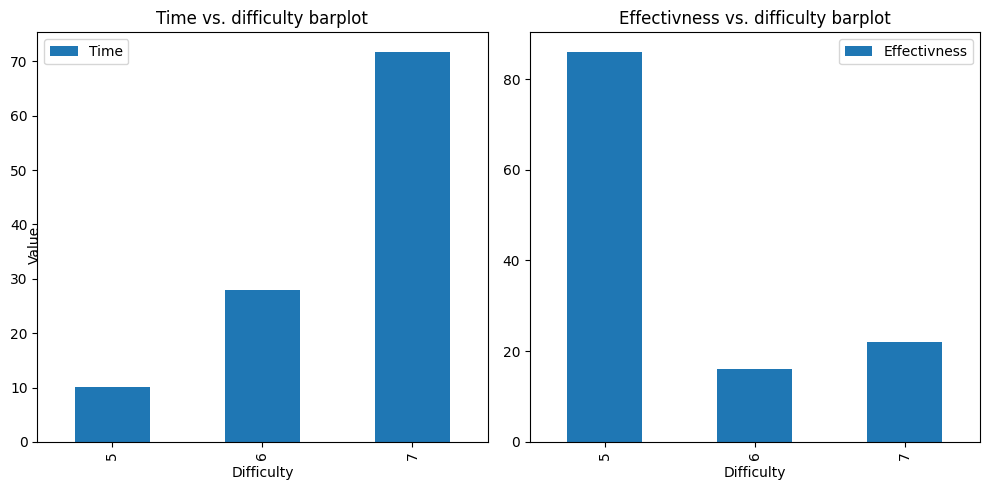

In [35]:
ga = {
  "Difficulty": [5, 6, 7],
  "Time": [easy_ga[1], medium_ga[1], hard_ga[1]],
    "Effectivness" : [easy_ga[0], medium_ga[0], hard_ga[0]]
    
}

#load data into a DataFrame object:
ga = pd.DataFrame(ga)


# Create figure and axis objects
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first barplot on the first axis
ga.plot.bar(x='Difficulty', y='Time', ax=ax[0])
ax[0].set_title('Time vs. difficulty barplot')

# Plot the second barplot on the second axis
ga.plot.bar(x='Difficulty', y='Effectivness', ax=ax[1])
ax[1].set_title('Effectivness vs. difficulty barplot')

# Set common ylabel and adjust layout
fig.text(0.04, 0.5, 'Value', ha='center', va='center', rotation='vertical')
plt.tight_layout()

# Show the plot
plt.show()

As we can see above our Genetic Algorithm isn't the best solution for the Nurikabe puzzle. The easiest (5x5) puzzle needed on average 10 seconds to solve and the effectivness was around 90% so this is not satisfying. The lowest score has the medium (6x6) puzzle which needed almost 30 seconds to be solved and the effectivness is around 15%. What is really interesting is the fact that the hardest (7x7) puzzle had an effectivness of almost 30% but the average time was more than 70 seconds which in addition to 100 iterations is really time consuming. Therefore, we evaluate that our algorithm works poorly.

## Second solution: solving Nurikabe using Particle Swarm Optimizer

In [36]:
# Import modules
import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history
from matplotlib import pyplot as plt
from pyswarms.discrete.binary import BinaryPSO

In [37]:
def solve_pso(nurikabe, difficulty):
    """
    Uses Particle Swarm Optimizer in order to get the solutionfor the nurikabe puzzle.


    Parameters
    ----------
    nurikabe :  ndarray
        puzzle which will be solved
    difficulty : int
        difficulty of the puzzle which will help to define:
            - number of iterations
            - number of neighbors to be considered

    Returns
    -------
    tuple
        solution to the given nurikabe puzzle and result of cost function
    """
    global solution, n_rows, n_cols
    
    # Will be used to convert the puzzle to a ndarray
    n_rows, n_cols = nurikabe.shape
    
    """
    all below function are defined the same as in the GA
    """
    
    def get_island_size(grid, row, col):
        grid_island = grid.copy()
        if grid_island[row, col] == 0:
            return 0

        size = 0
        queue = [(row, col)]
        while len(queue) > 0:
            r, c = queue.pop(0)
            if grid_island[r, c] == 1:
                size += 1
                grid_island[r, c] = -1
                if r > 0:
                    queue.append((r-1, c))
                if r < grid_island.shape[0]-1:
                    queue.append((r+1, c))
                if c > 0:
                    queue.append((r, c-1))
                if c < grid_island.shape[1]-1:
                    queue.append((r, c+1))

        return size


    def lake_is_connected(grid):
        grid_lake = grid.copy()
        grid_lake[grid_lake == 1] = -1

        lakes = []
        for row in range(grid_lake.shape[0]):
            for col in range(grid_lake.shape[1]):
                if grid_lake[row, col] == 0:
                    lake = []
                    queue = [(row, col)]
                    while len(queue) > 0:
                        r, c = queue.pop(0)
                        if grid_lake[r, c] == 0:
                            lake.append((r, c))
                            grid_lake[r, c] = -1
                            if r > 0:
                                queue.append((r-1, c))
                            if r < grid_lake.shape[0]-1:
                                queue.append((r+1, c))
                            if c > 0:
                                queue.append((r, c-1))
                            if c < grid_lake.shape[1]-1:
                                queue.append((r, c+1))
                    lakes.append(lake)

        for i in range(len(lakes)):
            for j in range(i+1, len(lakes)):
                if not any(cell in lakes[j] for cell in lakes[i]):
                    return False

        return True



    def lakes_have_numbers(grid):
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                if grid[i][j] == 0 and nurikabe[i][j] != 0:
                    return True
        return False



    def lake_2x2(grid):
        for i in range(grid.shape[0]-1):
            for j in range(grid.shape[1]-1):
                if grid[i][j] == 0 and grid[i+1][j] == 0 and grid[i][j+1] == 0 and grid[i+1][j+1] == 0:
                    return True
        return False

    
    def islands_connected(grid):
        indices = np.argwhere(grid == 1)
        adj_dict = {}
        for index in indices:
            adjacent = []
            if tuple(index - np.array([1, 0])) in adj_dict:
                adjacent.append(tuple(index - np.array([1, 0])))
            if tuple(index + np.array([1, 0])) in adj_dict:
                adjacent.append(tuple(index + np.array([1, 0])))
            if tuple(index - np.array([0, 1])) in adj_dict:
                adjacent.append(tuple(index - np.array([0, 1])))
            if tuple(index + np.array([0, 1])) in adj_dict:
                adjacent.append(tuple(index + np.array([0, 1])))
            adj_dict[tuple(index)] = adjacent
            for adj_index in adjacent:
                adj_dict[adj_index].append(tuple(index))
        groups = []
        while adj_dict:
            group = [list(adj_dict.keys())[0]]
            for index in group:
                for adj_index in adj_dict[index]:
                    if adj_index not in group:
                        group.append(adj_index)
            for index in group:
                del adj_dict[index]
            groups.append(group)
        coords_list = []
        for group in groups:
            coords = [tuple(index) for index in group]
            coords_list.append(coords)

        neighbors=coords_list

        islands = {}
        coords = np.argwhere(nurikabe != 0)
        for coord in coords:
            for neighbor in neighbors:
                for n in neighbor:
                    if (coord == n).all():
                        islands[tuple(coord)] = neighbor
                        break

        seen = set()
        duplicates = []

        for key, value in islands.items():
            for element in value:
                if element in seen:
                    duplicates.append((key, element))
                else:
                    seen.add(element)

        if duplicates:
            return True
        else:
            return False
    
    def fitness_func(solution):
        grid = solution.reshape((n_rows, n_cols))
        grid = grid.astype(int)
        
        fitness = 0

        x = np.where(nurikabe != 0)[0]
        y = np.where(nurikabe != 0)[1]
        for i in range(len(x)):
            if nurikabe[x[i]][y[i]] == get_island_size(grid, x[i], y[i]):
                fitness += 1
                
        if lake_is_connected(grid)==False:
            fitness -= 100

        if lakes_have_numbers(grid)==True:
            fitness -= 100

        if lake_2x2(grid)==True:
            fitness -= 100
        
        if islands_connected(grid)==True:
            fitness -= 100
            
        return fitness


    def f(x):
        n_particles = x.shape[0]
        j = [-fitness_func(x[i]) for i in range(n_particles)]
        return j

    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9, 'k': 10, 'p':1}

    optimizer = BinaryPSO(n_particles=100, dimensions=n_rows*n_cols, options=options)

    cost, solution=optimizer.optimize(f, iters=100*difficulty)

    return solution.reshape((n_rows, n_cols)), cost

In [38]:
easy_pso = time_effectivness(nurikabes_easy, nurikabes_easy_ans, 3, solve_pso)

2023-04-08 02:18:46,272 - pyswarms.discrete.binary - INFO - Optimize for 300 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|300/300, best_cost=-2
2023-04-08 02:19:03,249 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: -2.0, best pos: [0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0]
2023-04-08 02:19:03,260 - pyswarms.discrete.binary - INFO - Optimize for 300 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|300/300, best_cost=-1
2023-04-08 02:19:20,031 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: -1.0, best pos: [0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0]
2023-04-08 02:19:20,043 - pyswarms.discrete.binary - INFO - Optimize for 300 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.bi

2023-04-08 02:30:12,551 - pyswarms.discrete.binary - INFO - Optimize for 300 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|300/300, best_cost=-2
2023-04-08 02:30:31,440 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: -2.0, best pos: [1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1]
2023-04-08 02:30:31,452 - pyswarms.discrete.binary - INFO - Optimize for 300 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|300/300, best_cost=-2
2023-04-08 02:30:48,140 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: -2.0, best pos: [0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1]
2023-04-08 02:30:48,151 - pyswarms.discrete.binary - INFO - Optimize for 300 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.bi

2023-04-08 02:41:36,014 - pyswarms.discrete.binary - INFO - Optimize for 300 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|300/300, best_cost=-3
2023-04-08 02:41:54,172 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: -3.0, best pos: [1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1]
2023-04-08 02:41:54,183 - pyswarms.discrete.binary - INFO - Optimize for 300 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|300/300, best_cost=-2
2023-04-08 02:42:11,863 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: -2.0, best pos: [1 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1]
2023-04-08 02:42:11,873 - pyswarms.discrete.binary - INFO - Optimize for 300 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.bi

In [39]:
medium_pso = time_effectivness(nurikabes_medium, nurikabes_medium_ans, 4, solve_pso)

2023-04-08 02:47:58,732 - pyswarms.discrete.binary - INFO - Optimize for 400 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|400/400, best_cost=97
2023-04-08 02:48:40,168 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 97.0, best pos: [1 0 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 1 0]
2023-04-08 02:48:40,179 - pyswarms.discrete.binary - INFO - Optimize for 400 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|400/400, best_cost=97
2023-04-08 02:49:18,626 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 97.0, best pos: [1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 0]
2023-04-08 02:49:18,637 - pyswarms.discrete.binary - INFO - Optimize for 400 iters with {'c1': 0.5, 'c2': 0.3, 'w'

2023-04-08 03:11:44,079 - pyswarms.discrete.binary - INFO - Optimize for 400 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|400/400, best_cost=97
2023-04-08 03:12:25,314 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 97.0, best pos: [1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0]
2023-04-08 03:12:25,326 - pyswarms.discrete.binary - INFO - Optimize for 400 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|400/400, best_cost=96
2023-04-08 03:13:00,325 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 96.0, best pos: [1 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0]
2023-04-08 03:13:00,338 - pyswarms.discrete.binary - INFO - Optimize for 400 iters with {'c1': 0.5, 'c2': 0.3, 'w'

2023-04-08 03:34:55,388 - pyswarms.discrete.binary - INFO - Optimize for 400 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|400/400, best_cost=96
2023-04-08 03:35:34,351 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 96.0, best pos: [0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0]
2023-04-08 03:35:34,362 - pyswarms.discrete.binary - INFO - Optimize for 400 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|400/400, best_cost=-3
2023-04-08 03:36:08,065 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: -3.0, best pos: [1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1]
2023-04-08 03:36:08,078 - pyswarms.discrete.binary - INFO - Optimize for 400 iters with {'c1': 0.5, 'c2': 0.3, 'w'

In [40]:
hard_pso = time_effectivness(nurikabes_hard, nurikabes_hard_ans, 5, solve_pso)

2023-04-08 03:51:04,505 - pyswarms.discrete.binary - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|500/500, best_cost=96
2023-04-08 03:52:30,808 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 96.0, best pos: [0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 0
 1 0 0 0 0 1 0 1 0 1 0 1]
2023-04-08 03:52:30,823 - pyswarms.discrete.binary - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|500/500, best_cost=97
2023-04-08 03:53:54,766 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 97.0, best pos: [0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0
 0 0 0 0 1 1 0 1 0 1 0 1]
2023-04-08 03:53:54,780 - pyswarms.discrete.binary - INFO - 

2023-04-08 04:33:50,055 - pyswarms.discrete.binary - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|500/500, best_cost=99
2023-04-08 04:35:02,201 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 99.0, best pos: [1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 0
 1 0 1 1 0 0 0 0 1 1 1 0]
2023-04-08 04:35:02,214 - pyswarms.discrete.binary - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|500/500, best_cost=98
2023-04-08 04:36:04,696 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 98.0, best pos: [1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0
 0 0 0 0 1 1 0 1 0 1 0 0]
2023-04-08 04:36:04,710 - pyswarms.discrete.binary - INFO - 

2023-04-08 05:14:36,030 - pyswarms.discrete.binary - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|500/500, best_cost=99
2023-04-08 05:15:44,782 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 99.0, best pos: [1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0
 0 0 0 1 0 0 0 1 0 1 1 0]
2023-04-08 05:15:44,796 - pyswarms.discrete.binary - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████████|500/500, best_cost=99
2023-04-08 05:17:09,576 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 99.0, best pos: [1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1
 0 1 0 1 1 0 0 0 0 0 1 1]
2023-04-08 05:17:09,590 - pyswarms.discrete.binary - INFO - 

In [41]:
pso = {
  "Difficulty": [5, 6, 7],
  "Time": [easy_pso[1], medium_pso[1], hard_pso[1]],
    "Effectivness" :[easy_pso[0], medium_pso[0], hard_pso[0]]
    
}

pso = pd.DataFrame(pso)

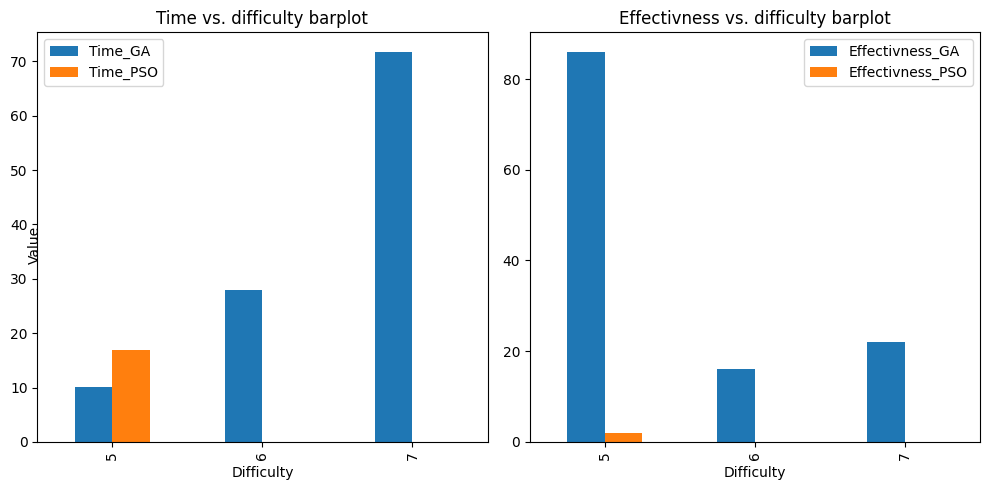

In [42]:
pso_ga = pd.merge(ga, pso, on='Difficulty', suffixes=('_GA', '_PSO'))

# Create figure and axis objects
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first barplot on the first axis
pso_ga.plot.bar(x='Difficulty', y=["Time_GA", "Time_PSO"], ax=ax[0])
ax[0].set_title('Time vs. difficulty barplot')

# Plot the second barplot on the second axis
pso_ga.plot.bar(x='Difficulty', y=["Effectivness_GA", "Effectivness_PSO"], ax=ax[1])
ax[1].set_title('Effectivness vs. difficulty barplot')

# Set common ylabel and adjust layout
fig.text(0.04, 0.5, 'Value', ha='center', va='center', rotation='vertical')
plt.tight_layout()

# Show the plot
plt.show()

In [44]:
pso

,Difficulty,Time,Effectivness
0,5,16.837031,2
1,6,0.000000,0
2,7,0.000000,0


In [45]:
ga

,Difficulty,Time,Effectivness
0,5,10.092641,86
1,6,28.005506,16
2,7,71.767844,22


As we can see above the PSO algorithm works really poorly. It found only two results for the (5x5) puzzle and din't find any results for the (6x6) puzzles and (7x7) puzzles. I found it really disappointing because the PSO algorithm was much more time consuming (it took 4 hours) and resulted in poor results. All in all, the genetic algorithm works better.